<a href="https://colab.research.google.com/github/taylan-sen/CIS490a_intro_ai/blob/main/URDF_intro_with_pybullet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to URDF using colab and pybullet

Robot hardware is expensive. It is also often much faster to test robots out in simulated environments before using them in the real world. **URDF** is a simple language for describing a robot's physical links and joints, and **pybullet** is a physics simulation environment that supports URDF that runs in jupyter/colab.

**URDF** = Uniform Robot Description Format (this is a an extensible markup language for describing:
1. Robot visual definition
1. robot physical/collision properties

**pybullet** = physics simulation environment (a python wrapper for bullet), which supports URDF and joint control, as well as provides graphical output through extensive camera controls.

**ffmpeg** - video processor (produces mp4 video based on pybullet output)

See http://wiki.ros.org/urdf/Tutorials for detailed description of urdf syntax.

See https://pybullet.org/wordpress/index.php/forum-2/ for documentation on pybullet.

## Installing PyBullet

Installing pybullet takes about 20 minutes. We don't want to have to go through this everytime we use this notebook in colab (remember that everytime you disconnect from a colab runtime the virtual machine environment that was set up for you, with all your manually installed python packages, gets deleted). There is a way to install pybullet once, then "mount" this installation each time you start up your notebook (which is a lot faster than reinstalling pybullet each time.  

In order to do this, in summary we will:
1. Allow this notebook to access our google drive (aka mount Google drive)
1. We will install a tool for creating a new python environment called **virtualenv**
1. We will create a new python virtual environment.
1. We will install pybullet in this virtual environment.

In [1]:
# Run this everytime
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


* The two cells below should only be run once.
* They create the python virtual environment on your google drive and install to it pybullet (and the ffmpeg video processor).

In [ ]:
# run this only once; comment it out after you run it
!pip install virtualenv
!virtualenv /content/drive/MyDrive/colab_env

In [1]:
# run this once; comment it out after you run it
# Install pybullet and ffmpeg into the virtualenv
# You need to do only once - not each time you open the notebook
# It takes a while. (~15 minutes)
!source /content/drive/MyDrive/colab_env/bin/activate; pip install pybullet imageio-ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.5-cp310-cp310-linux_x86_64.whl size=99850148 sha256=36459ca5ef790bba456dc6cda23189aaf820bb64ce8f0db167b5cffed248b892
  Stored in directory: /root/.cache/pip/wheels/6b/fa/1a/c315a5133f0c9bf202a6daa5d70891120e7fe403e06e3407cc
Successfully built pybullet


* At this point our one-time installation is complete.  
* Each time we reopen this notebook, we will need to run the cell below to link in the python virtualenv on our google drive to access pybullet.

In [3]:
# Run this everytime
# import our pybullet installation from our drive
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

In [4]:
import pybullet as p              # this is the physics simulator & visualizer
import pybullet_data              # tools to interact with datafiles (get path)
import imageio_ffmpeg             # video transcoder
import math                       # for access to trig (pi, cos)
import numpy as np                # numerical python, fast matrix computation
from PIL import Image # typo      # image processing
import matplotlib.pyplot as plt   # plotting (plot a single frame)
from base64 import b64encode      #
from IPython.display import HTML  # to display html in markdown cells


In [8]:
# Write a custom robot URDF.
#
# Our robot will have a vertical cylinder base connected to a horizontal arm
# through a revolute (hinge) joint rotating in the z-axis.
#
# ROBOT: myrobot
#
# JOINTS:               base_to_arm
# LINKS:    base_link-----------------arm
# SHAPE:    vertical                  horizontal
#           cylinder                  cylinder
#
my_urdf = '''
<?xml version="1.0"?>
<robot name="myrobot">

  <link name="base_link">
    <visual>
      <geometry>
        <cylinder length="0.05" radius="0.1"/>
      </geometry>
      <material name="blue">
        <color rgba="0 0 .8 1"/>
      </material>
    </visual>
    <collision>
      <geometry>
        <cylinder length="0.05" radius="0.1"/>
      </geometry>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <link name="arm">
    <visual>
      <geometry>
        <box size="0.1 0.6 0.05"/>
      </geometry>
      <material name="white">
        <color rgba="0.8 0.8 0.8 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0.3 0.03"/>
    </visual>
    <collision>
      <geometry>
        <box size="0.1 0.6 0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0.3 0.03"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="base_to_arm" type="revolute">
    <parent link="base_link"/>
    <child link="arm"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0 0"/>
    <limit effort="1000.0" lower="0.0" upper="3.14" velocity="0.5"/>
  </joint>

</robot>
'''

f = open('custom_robot1.urdf', 'w')
f.write(my_urdf)
f.close()

with open('custom_robot1.urdf', 'w') as f:
    f.write(my_urdf)

What do each of the following URDF tags mean?
* robot:
  * link
    * visual
    * collision
    * inertial
  * joint
    * parent
    * child
    * axis
    * origin

Num of joints in robot: 1


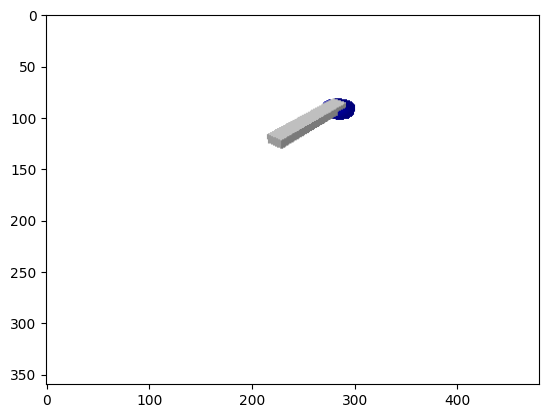

In [9]:
# In this cell, we load our robot, set a camera point of view, then display
# the robot by getting an image from pybullet and plotting it with matplotlib.
#
#---------------------------------------------------------------------
# Start the pybullet env
# add the directory that has our urdf file to the seach path
p.connect(p.DIRECT) # or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

robot_id = p.loadURDF("custom_robot1.urdf",
                      basePosition=[1.400000, -0.200000, 0.650000],
                      useFixedBase=True)
p.resetJointState(robot_id, 0, math.pi/2) # set the starting joint position

print('Num of joints in robot:', p.getNumJoints(robot_id))

#---------------------------------------------------------------------
# Set up the "camera" point of view
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360
cam_up, cam_up_axis_idx = [0, 0, 1], 2
cam_near_plane, cam_far_plane = 0.01, 100
cam_fov = 60

cam_view_params = (cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll,
                   cam_up_axis_idx)
cam_matrix_params = (cam_fov, cam_width*1./cam_height, cam_near_plane,
                     cam_far_plane)

#---------------------------------------------------------------------
cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(*cam_view_params)
cam_projection_matrix = p.computeProjectionMatrixFOV(*cam_matrix_params)
image = p.getCameraImage(cam_width, cam_height,
                         cam_view_matrix, cam_projection_matrix
                        )[2][:, :, :3]


plt.imshow(Image.fromarray(image)) # show the last frame

p.disconnect()

Num of joints in robot: 1
timestep 1199...

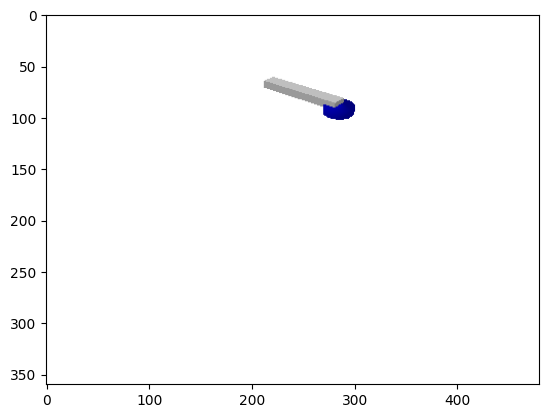

In [10]:
#---------------------------------------------------------------------
# Start the pybullet env
# add the directory that has our urdf file to the seach path
p.connect(p.DIRECT) # or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

robot_id = p.loadURDF("custom_robot1.urdf",
                      basePosition=[1.400000, -0.200000, 0.650000],
                      useFixedBase=True)
print('Num of joints in robot:', p.getNumJoints(robot_id))

#---------------------------------------------------------------------
# Set up the "camera" point of view
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360

cam_up, cam_up_axis_idx = [0, 0, 1], 2
cam_near_plane, cam_far_plane = 0.01, 100
cam_fov = 60

cam_view_params = (cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll,
                   cam_up_axis_idx)
cam_matrix_params = (cam_fov, cam_width*1./cam_height, cam_near_plane,
                     cam_far_plane)

#---------------------------------------------------------------------
# Start the video filewriter
vid = imageio_ffmpeg.write_frames('vid.mp4', (cam_width, cam_height), fps=30)
vid.send(None) # seed the video writer with a blank frame

#---------------------------------------------------------------------
# run the simulation for n steps
# PyBullet default simulation time step is 240fps,
# but we want to record video at 30fps.

n = 1200 # number of time steps to simulate

for t in range(n):
    print(f'\rtimestep {t}...', end='')

    # every 8 time steps, create one video frame
    if t % 8 == 0:
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(*cam_view_params)
        cam_projection_matrix = p.computeProjectionMatrixFOV(*cam_matrix_params)
        image = p.getCameraImage(cam_width, cam_height,
                                 cam_view_matrix, cam_projection_matrix
                                 )[2][:, :, :3]
        vid.send(np.ascontiguousarray(image))

    # every 1200 time steps, joint will cycle from 0 to 180]
    joint_angle = 0.5 * math.pi * (1 - math.cos(2*math.pi*t/1200))
    p.setJointMotorControl2(bodyIndex=robot_id,
                            jointIndex=0,
                            controlMode=p.POSITION_CONTROL,
                            targetPosition=joint_angle)
    p.stepSimulation()

plt.imshow(Image.fromarray(image)) # show the last frame

vid.close()
p.disconnect()

In [11]:
# Play recorded video

mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

## Skills

* Try changing the color of the base from blue to red.
* Try changing the height of the base.
* Try changing the length of the arm.